In [2]:
import numpy as np
import sys, pickle, csv
import cv2

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as VGG19_preprocess
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as InceptionV3_preprocess
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as ResNet50V2_preprocess
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as Xception_preprocess

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from XAI_method.gradcam import GradCam
from XAI_method.XAI_lime import XAI_lime

%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # memory increase is needed before starting program
        print(e)


In [ ]:
# load dataset

image_dim = 384


#dpath_original = 'D:kvasir_cls/kvasir-dataset-v2'
dpath_preprocess = 'D:kvasir_cls'

with open(dpath_preprocess +'/kvasir_cls_'+str(image_dim)+'no_polyp'+'.pickle', 'rb') as f:
    [X,Y] = pickle.load(f)
    print(X.shape, Y.shape)

with open(dpath_preprocess +'/kvasir_cls_'+str(image_dim)+'polyp' + '.pickle', 'rb') as w:
    [X_polyp, Y_polyp] =  pickle.load(w)
    print(X_polyp.shape, Y_polyp.shape)

assert np.max(X) == 255
assert np.min(X) == 0
assert np.max(X_polyp) == 255
assert np.min(X_polyp) == 0

# rest dataset split
X_trnval_no, X_tst_no, Y_trnval_no, Y_tst_no = train_test_split(X, Y, test_size = 1.5 / 10, random_state = 27407, stratify = Y)
X_trn_no, X_val_no, Y_trn_no, Y_val_no = train_test_split(X_trnval_no, Y_trnval_no, test_size = 1.5 / 8.5, random_state = 27407, stratify = Y_trnval_no)

# polyp split
X_trnval_polyp, X_tst_polyp, Y_trnval_polyp, Y_tst_polyp = train_test_split(X_polyp, Y_polyp, test_size = 1.5 / 10, random_state = 27407)
X_trn_polyp, X_val_polyp, Y_trn_polyp, Y_val_polyp = train_test_split(X_trnval_polyp, Y_trnval_polyp, test_size = 1.5 / 8.5, random_state = 27407)

# concatenation and onehot encoding
enc = OneHotEncoder(sparse=False)

X_trn = np.concatenate((X_trn_no, X_trn_polyp), axis=0)
Y_trn = np.concatenate((Y_trn_no, Y_trn_polyp))
Y_trn = enc.fit_transform(Y_trn)

n_class = Y_trn.shape[1]
print("total class number: ", n_class)

X_val = np.concatenate((X_val_no, X_val_polyp), axis=0)
Y_val = np.concatenate((Y_val_no, Y_val_polyp), axis=0)
Y_val = enc.fit_transform(Y_val)

X_tst = np.concatenate((X_tst_no, X_tst_polyp), axis=0)
Y_tst = np.concatenate((Y_tst_no, Y_tst_polyp), axis=0)
Y_tst = enc.fit_transform(Y_tst)


print('trn.shape', X_trn.shape, Y_trn.shape)
print('val.shape', X_val.shape, Y_val.shape)
print('tst.shape', X_tst.shape, Y_tst.shape)

with open("D:/"+"kvasir" + "/kvasir_" + str(image_dim) + '.pickle', 'rb') as q:
    [X_seg, Y_seg] = pickle.load(q)
    print(X_seg.shape, Y_seg.shape)
    
Y_seg = np.expand_dims(Y_seg, 3)

assert np.max(X_seg) == 255
assert np.min(X_seg) == 0
assert np.max(Y_seg) == 1
assert np.min(Y_seg) == 0

# polyp split
X_trnval_s, X_tst_s, Y_trnval_s, Y_tst_s = train_test_split(X_seg, Y_seg, test_size = 1.5 / 10, random_state = 27407)
X_trn_s, X_val_s, Y_trn_s, Y_val_s = train_test_split(X_trnval_s, Y_trnval_s, test_size = 1.5 / 8.5, random_state = 27407)


(7000, 384, 384, 3) (7000, 1)
(1000, 384, 384, 3) (1000, 1)


In [ ]:
model_id = 3   # 0, 1, 2, 3
model_list = ["VGG19", "InceptionV3", "ResNet50V2", "Xception"]

if model_id == 0:
    model = load_model('D:kvasir_cls/models/' + 'kvasir_cls_' + model_list[model_id] + '.h5')
    preprocess_func = VGG19_preprocess
    last_conv_layer_name = 'block5_conv4'
elif model_id == 1:
    model = load_model('D:kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id ] + '.h5')
    preprocess_func = InceptionV3_preprocess
    last_conv_layer_name = 'mixed10'
elif model_id == 2:
    model = load_model('D:kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id ] + '.h5')
    preprocess_func = ResNet50V2_preprocess
    last_conv_layer_name = 'conv5_block3_out'
elif model_id == 3:
    model = load_model('D:kvasir_cls/models/' +'kvasir_cls_' + model_list[model_id ] + '.h5')
    preprocess_func = Xception_preprocess
    last_conv_layer_name = 'block14_sepconv2_act'

In [ ]:
# polyp dataset preprocessing
X_tst_s_preprocessed = preprocess_func(X_tst_s)

#X_tst_s = preprocess_func(X_tst_s)
#X_tst = preprocess_func(X_tst)


#batch_size = 16
#Y_tst_hat = model.predict(X_tst, batch_size=batch_size)
#accuracy = accuracy_score(np.argmax(Y_tst, 1), np.argmax(Y_tst_hat, 1))
#print(accuracy)

In [ ]:
gradcam = GradCam(model, last_conv_layer_name)
lime = XAI_lime(model, model_list[model_id], preprocess_func)

  0%|          | 0/1000 [00:00<?, ?it/s]

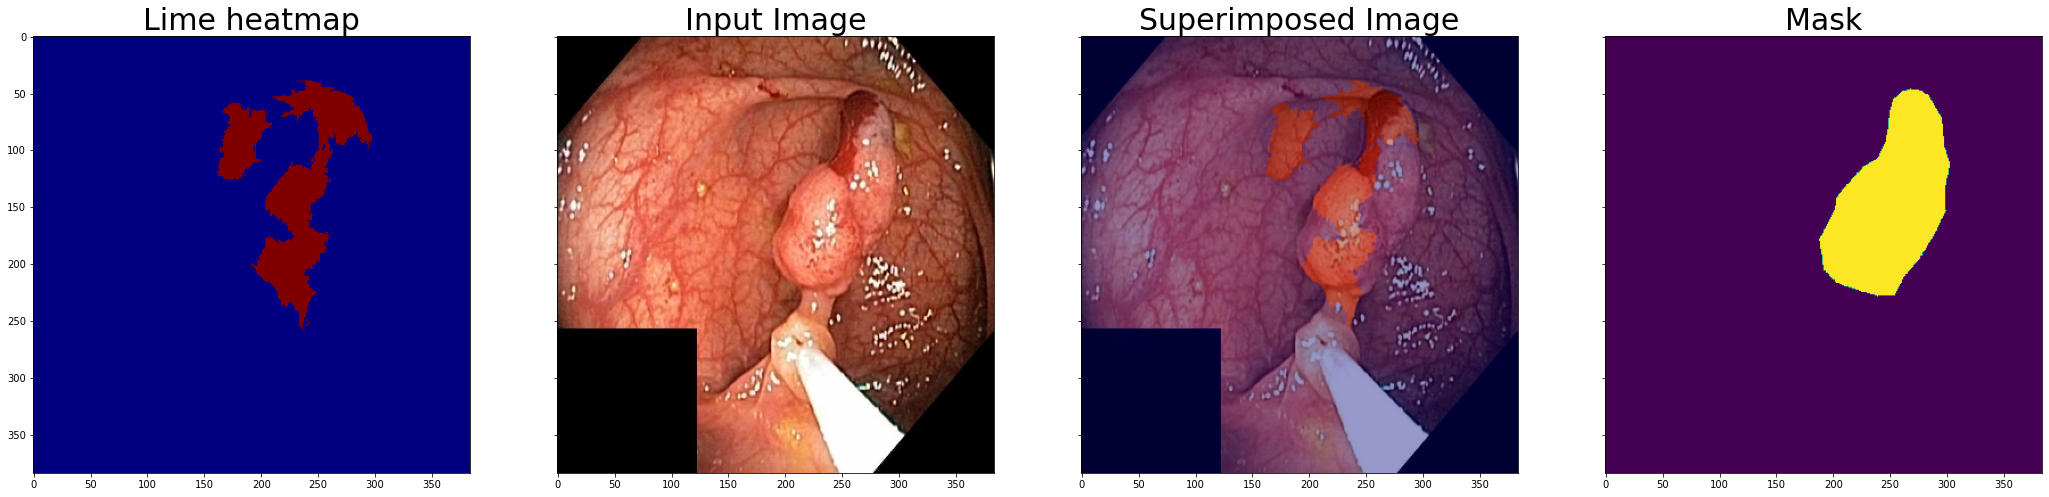

In [8]:
num = 5

lime.lime_single_visualize(X_tst_s[num], Y_tst_s[num], 0.4)

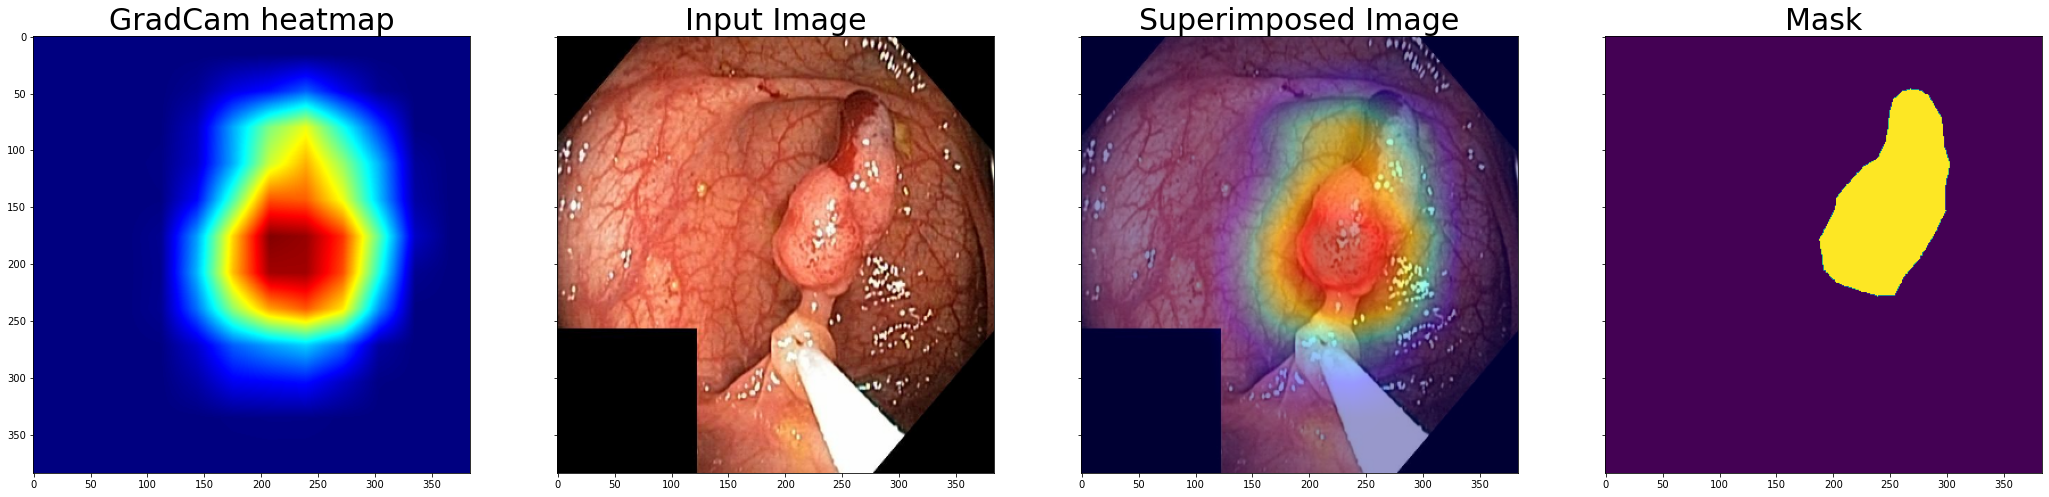

In [7]:
heatmap, decoded, super123 = gradcam.gradcam_visualize(X_tst_s_preprocessed[num], Y_tst_s[num], 0.4)

In [1]:
heatmap

NameError: name 'heatmap' is not defined

In [9]:
import lime
from lime import lime_image

In [10]:
explainer = lime_image.LimeImageExplainer(verbose=True)

In [11]:
explanation = explainer.explain_instance(X_tst_s_preprocessed[5].astype('double'), model, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.031097368101025657
Prediction_local [0.00639955]
Right: 5.588601e-05
Intercept 0.09870388873527464
Prediction_local [0.13303538]
Right: 0.0001773114
Intercept 0.046753556295436996
Prediction_local [0.0185441]
Right: 0.0002997032
Intercept 0.08339814816322058
Prediction_local [0.01626713]
Right: 0.0010751204
Intercept 0.7052063763089913
Prediction_local [0.8362643]
Right: 0.99824464


In [27]:
explanation.top_labels

[7, 1, 3, 2, 6]

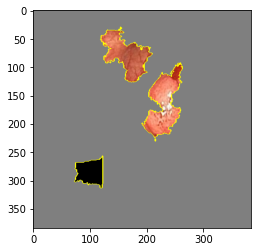

In [12]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

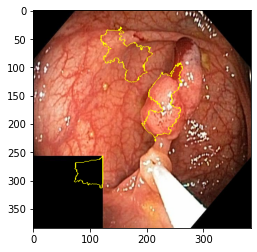

In [13]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

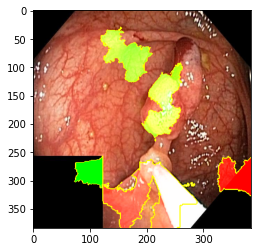

In [14]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

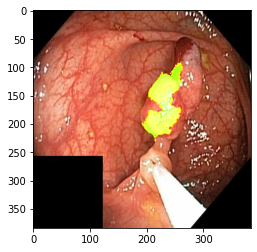

In [15]:

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

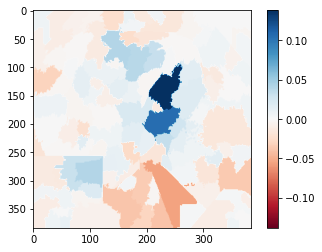

In [29]:

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [1]:
heatmap

NameError: name 'heatmap' is not defined

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [33]:
Y_tst_s[5].ravel().shape

(147456,)

In [34]:
heatmap.ravel().shape

(147456,)

In [35]:
fpr, tpr, _ = roc_curve(Y_tst_s[5].ravel(), heatmap.ravel())
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.8623880742306135


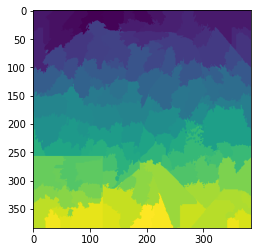

In [25]:
plt.imshow(explanation.segments)

In [11]:
gradcam.gradcam_single_auroc(X_tst_s[2], Y_tst_s[2])

0.9420495992263425

In [ ]:
plt.imshow(Y_tst_s[0])

In [16]:
gradcam.gradcam_total_auroc(X_tst_s, Y_tst_s)

0.9007376076578125

In [33]:
preprocess_func = Xception_preprocess

In [10]:
def resnet_de(img_array):
    img_array /= 2.
    img_array += 0.5
    img_array *= 255.
    return img_array

In [29]:
resnet_de(preprocess_func(X_trn_s[0])).max()

255.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


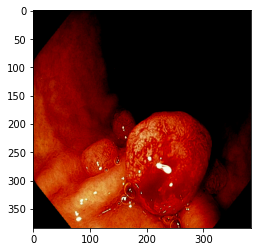

In [9]:
plt.imshow(preprocess_func(X_trn_s[0]))

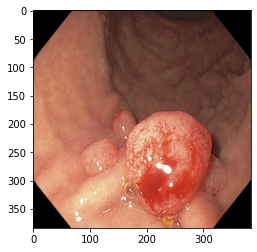

In [11]:
plt.imshow(resnet_de(preprocess_func(X_trn_s[0])).astype('uint8'))